In [1]:
# import the standard numerical libraries and setup plotting
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# use a matplotlib style file from my server to set nicer defaults for the plots
# the default line colors are chosen to be also distinguishable for colorblind people
plt.style.use("https://johannesfeist.eu/misc/jf_cb.mplstyle")

In [3]:
from qutip import *

In [4]:
"Helper function to convert qutip string form to function"
def eval_fstr(fstr,args,doprint=False):
    feval = fstr
    for k,v in args.items():
        feval = feval.replace(k,str(v))
    feval = feval.replace("cos","np.cos").replace("exp","np.exp").replace("sin","np.sin").replace("pi","np.pi")
    if doprint:
        print("Function string with replaced parameters:",feval)
    return eval("lambda t: "+feval)

Tip: enter greek letters with the latex code + tab key, e.g., `\alpha + [tab]` gives α.

# QuTiP implementation of Jaynes-Cummings model (single emitter + single cavity)

Make a Hamiltonian and Liouvillian superoperator for a single emitter (2 levels) and a cavity mode (numerically approximated with N levels). Since our system consists of two subsystems (emitter and cavity), all operators are tensor products, e.g., $a = a_c \otimes I_e$, where the subscript $c$ or $e$ indicates that it is an operator in the cavity or emitter Hilbert space, and $I$ is the identity operator (obtained with `qeye` in qutip).

We use $\sigma$ to represent $\sigma^-$, such that $\sigma^\dagger = \sigma^+$, to make the analogy with $a$ and $a^\dagger$ direct. Note that we also use a two-level `destroy` operator to construct $\sigma$, not the "native" `sigmam` operator (in which the ordering of states in the basis is reversed for some reason).

Note that we do NOT use the rotating wave approximation for the molecule-cavity interaction. 

## Hamiltonian
\begin{align}
  H &= H_0 + \textbf{E}(t) \cdot \hat{\boldsymbol{\mu}}_c\\
  H_0 &= \omega_e \sigma^+ \sigma^- + \omega_c a^\dagger a + g (\sigma^- + \sigma^+) (a + a^\dagger)\\
  \hat{\boldsymbol{\mu}}_c &= \boldsymbol{\mu}_c (a^\dagger + a)
\end{align}

In QuTiP, a time-dependent Hamiltonian is most efficiently passed as a list of terms with the time-dependence described by strings (see http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html#string-format-method).

We below use $\mathbf{E}(t) = \mathbf{E}_0 \sin\left(\frac{\pi t}{T}\right)^2 \sin(\omega_L t)$ for $0\leq t \leq T$ and $E(t) = 0$ otherwise, i.e., a laser pulse at frequency $\omega_L$ with a $\sin^2$ envelope with duration $T$, and define $\Omega = \mathbf{E}_0 \cdot \boldsymbol{\mu}_c$.

## Parameters

In [5]:
N = 5 # number of levels for the cavity mode, to represent up to N-1 photons
σ = tensor(qeye(N),destroy(2))
a = tensor(destroy(N),qeye(2))

ωe = 1.
ωc = 1.
g = 0.1

# Laser pulse parameters
Estr = 'Omega * ((0<t)&(t<T)) * sin(pi*t/T)**2 * sin(omegaL*t)'
args = dict(omegaL = 1.1,  # frequency
            T      = 200., # duration
            Omega  = 0.04)  # peak amplitude (μ·E0)

In [6]:
# write H0 without 
H0 = ωe*σ.dag()*σ + ωc*a.dag()*a + g*(σ+σ.dag())*(a+a.dag())
Ht = a.dag()+a
# Hamiltonian is H0 plus Ht*E(t) with E(t) described by the string Estr
H = [H0,[Ht,Estr]]

In [40]:
H

[Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
 Qobj data =
 [[0.         0.         0.         0.1        0.         0.
   0.         0.         0.         0.        ]
  [0.         1.         0.1        0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.1        1.         0.         0.         0.14142136
   0.         0.         0.         0.        ]
  [0.1        0.         0.         2.         0.14142136 0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.14142136 2.         0.
   0.         0.17320508 0.         0.        ]
  [0.         0.         0.14142136 0.         0.         3.
   0.17320508 0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.17320508
   3.         0.         0.         0.2       ]
  [0.         0.         0.         0.         0.17320508 0.
   0.         4.         0.2        0.        ]
  [0.       

In [7]:
args['omegaL']

1.1

Function string with replaced parameters: 0.04 * ((0<t)&(t<200.0)) * np.sin(np.pi*t/200.0)**2 * np.sin(1.1*t)


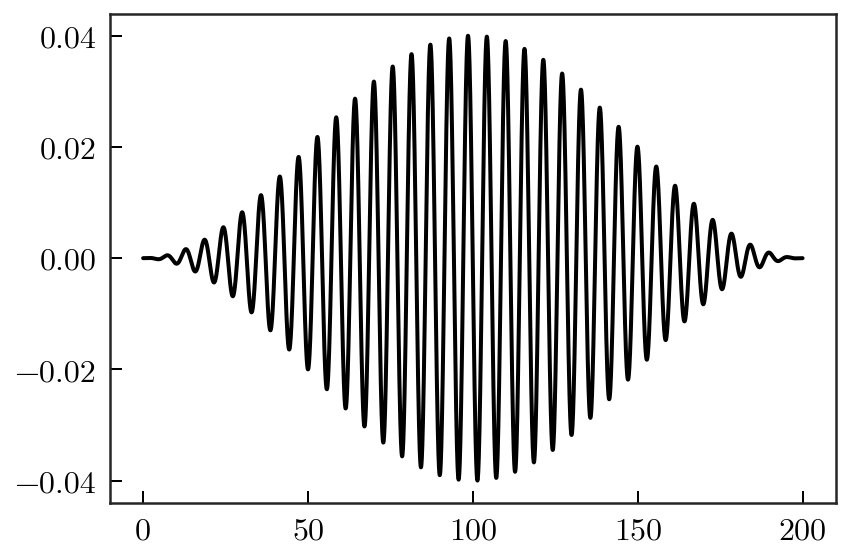

In [7]:
Efun = eval_fstr(Estr,args,True)
ts = np.linspace(0,args['T'],5001)
plt.plot(ts,Efun(ts));

In [8]:
vals,vecs = H0.eigenstates()
ψ0 = vecs[0] # initial state is the ground state
tmax = 1.2*args['T']
# equally spaced grid with ~12 points per pulse cycle
# (just for output, integration step is chosen automatically by qutip)
ts = np.arange(0,tmax,0.5/args['omegaL'])

In [41]:
ψ0

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 9.98739804e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.00621448e-02]
 [ 3.54435299e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.53666107e-04]
 [ 7.67368919e-06]
 [ 0.00000000e+00]]

[-5.01253125e-03  8.95102299e-01  1.09484707e+00  1.85388952e+00
  2.13600911e+00  2.82249197e+00  3.16760914e+00  3.80817270e+00
  4.20694120e+00  5.01994952e+00]


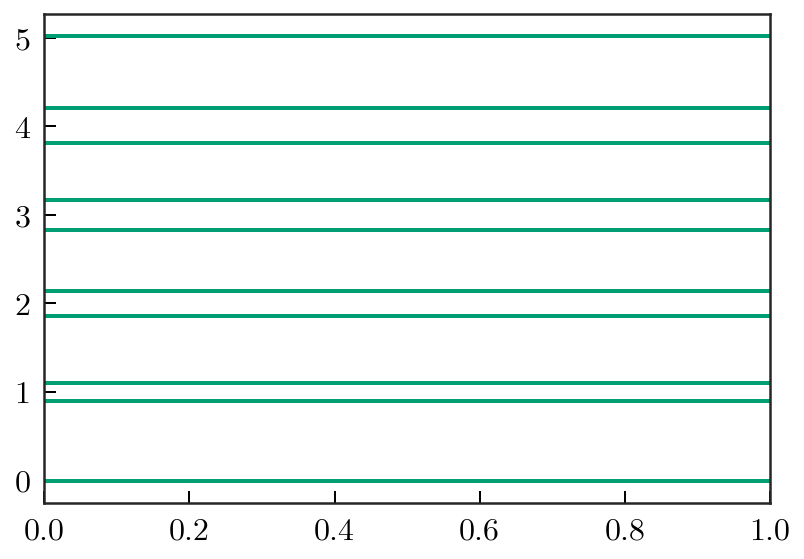

In [9]:
print(vals)
for v in vals:
    plt.axhline(v,color="C3")

## Solve Time-Dependent Schrödinger equation
This is done with `sesolve` in QuTiP (for "Schrödinger Equation SOLVE")

In [10]:
result = sesolve(H,ψ0,ts,args=args,options=Options(rtol=1e-8,atol=1e-10))
result

Result object with sesolve data.
--------------------------------
states = True
num_collapse = 0

In [42]:
result.states

[Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
 Qobj data =
 [[ 9.98739804e-01]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [-5.00621448e-02]
  [ 3.54435299e-03]
  [ 0.00000000e+00]
  [ 0.00000000e+00]
  [-1.53666107e-04]
  [ 7.67368919e-06]
  [ 0.00000000e+00]],
 Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
 Qobj data =
 [[ 9.98737211e-01+2.27555006e-03j]
  [-5.31632057e-10+5.80535520e-09j]
  [-1.02513401e-08-1.13133090e-07j]
  [-5.00620148e-02-1.14062658e-04j]
  [ 3.54434379e-03+8.07552939e-06j]
  [ 7.27738922e-10+8.00970297e-09j]
  [-6.31819560e-11-6.93632726e-10j]
  [-1.53665708e-04-3.50116133e-07j]
  [ 7.67366927e-06+1.74838970e-08j]
  [ 3.16950740e-12+3.46324037e-11j]],
 Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
 Qobj data =
 [[ 9.98729434e-01+4.55108831e-03j]
  [-1.44579148e-08+8.98623033e-08j]
  [-2.96362627e-07-1.61651322e-06j]
  [-5.00616250e-02-2.28124724e-04j]
  [ 3.54431619e-03+1.61510176e-05j]
  [ 2.1

[Text(0, 0.5, '$\\langle N \\rangle$')]

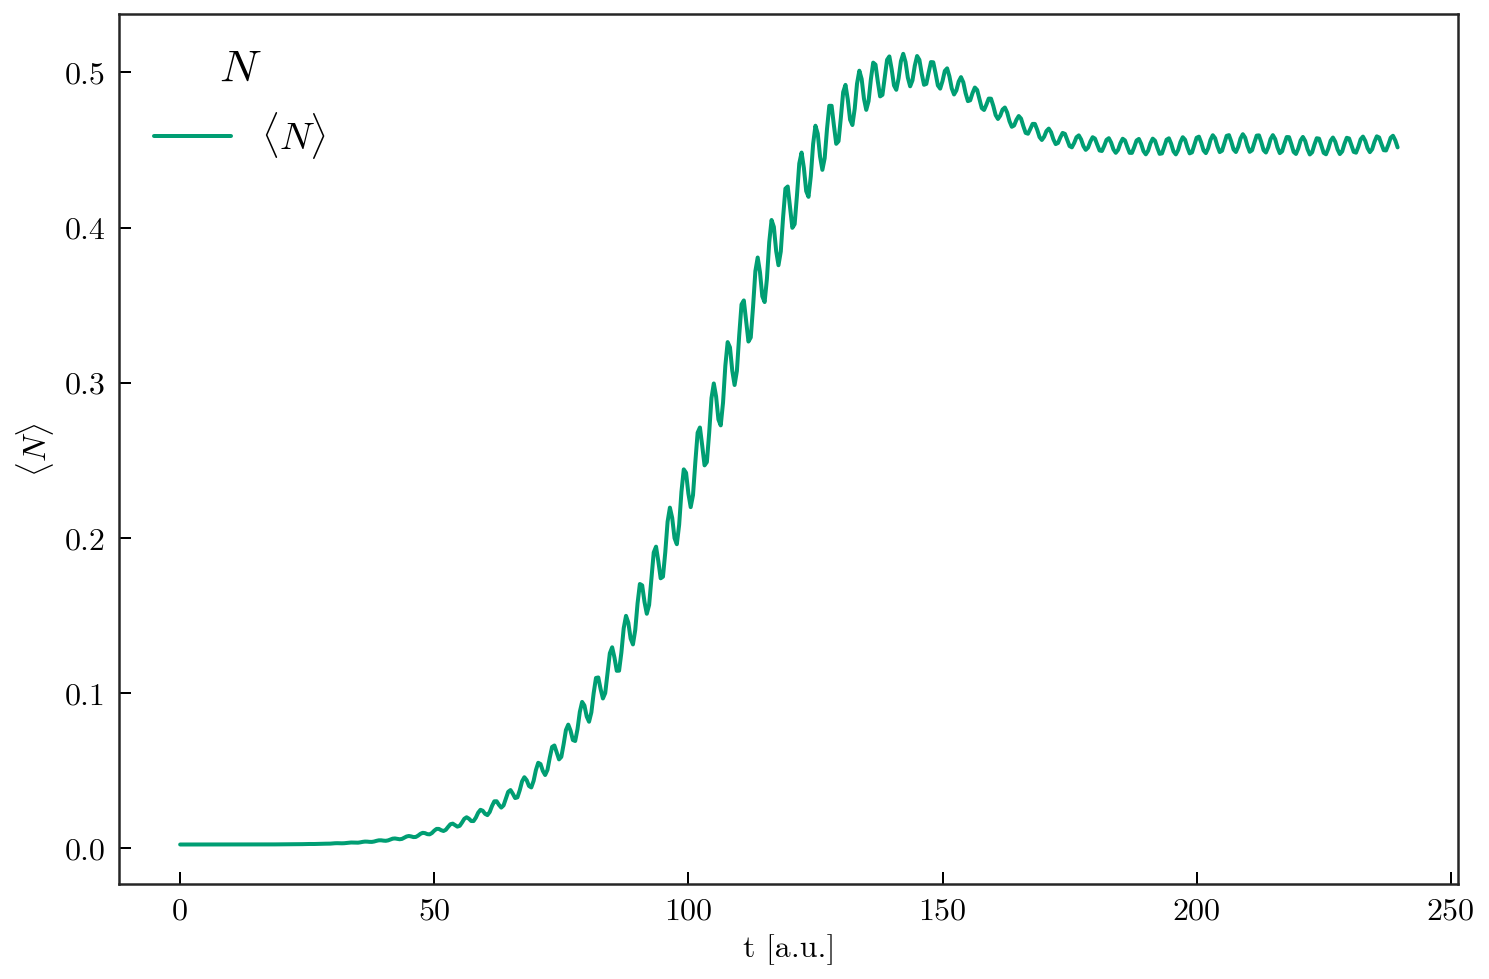

In [12]:
expectn1 = expect(a.dag()*a,result.states)
fig, ax = plt.subplots(1, 1,figsize=(12, 8))
ax.plot(ts,expectn1,color="C3",lw=2,label=r'$\langle N \rangle$')
leg = ax.legend(loc=2,fontsize = 'large')
leg.set_title(r'$N$', prop = {'size':'x-large'})
ax.set(xlabel='t [a.u.]')
ax.set(ylabel=r'$\langle N \rangle$')
#plt.rc('font', size = 18)

In [13]:
result.states[0]

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 9.98739804e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-5.00621448e-02]
 [ 3.54435299e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.53666107e-04]
 [ 7.67368919e-06]
 [ 0.00000000e+00]]

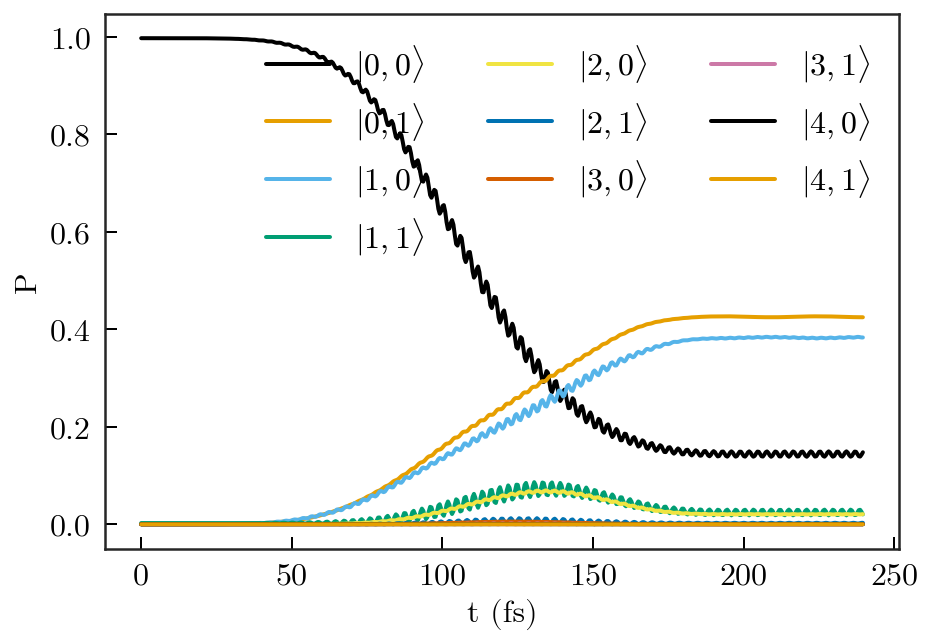

In [14]:
ψs = np.array([ψ.full() for ψ in result.states])
probs = (abs(ψs)**2).reshape(len(ts),N,2)
probs.shape
for ic in range(N):
    for ie in range(2):
        plt.plot(result.times,probs[:,ic,ie],label=fr"$|{ic},{ie}\rangle$");
plt.legend(ncol=3)
plt.xlabel("t (fs)")
plt.ylabel("P")
plt.tight_layout(pad=0.5)

In [15]:
ψs = np.array([ψ.full() for ψ in result.states]).squeeze()
probs = (abs(ψs)**2).reshape(len(ts),N,2)
probs.shape

(528, 5, 2)

In [24]:
probs

array([[[9.97481196e-01, 0.00000000e+00],
        [0.00000000e+00, 2.50621834e-03],
        [1.25624381e-05, 0.00000000e+00],
        [0.00000000e+00, 2.36132724e-08],
        [5.88855058e-11, 0.00000000e+00]],

       [[9.97481196e-01, 3.39847817e-17],
        [1.29041860e-14, 2.50621834e-03],
        [1.25624381e-05, 6.46849456e-17],
        [4.85118318e-19, 2.36132724e-08],
        [5.88855058e-11, 1.20944916e-21]],

       [[9.97481196e-01, 8.28426485e-15],
        [2.70094580e-12, 2.50621834e-03],
        [1.25624381e-05, 1.35403039e-14],
        [1.01544216e-16, 2.36132723e-08],
        [5.88855056e-11, 2.53018818e-19]],

       ...,

       [[1.38908580e-01, 4.24855446e-01],
        [3.83867553e-01, 2.96818781e-02],
        [2.01647135e-02, 2.26490884e-03],
        [7.49197680e-05, 1.78729220e-04],
        [2.52475634e-06, 7.46745647e-07]],

       [[1.42713745e-01, 4.24802541e-01],
        [3.83353234e-01, 2.56054335e-02],
        [2.04235157e-02, 2.88421983e-03],
        [2.31

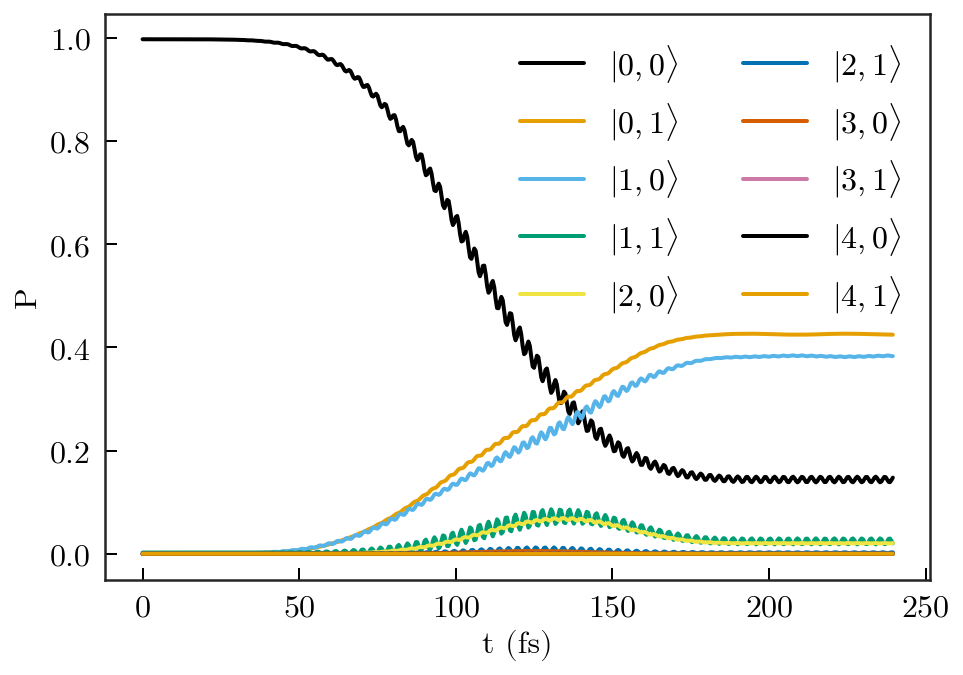

In [15]:
for ic in range(N):
    for ie in range(2):
        plt.plot(result.times,probs[:,ic,ie],label=fr"$|{ic},{ie}\rangle$");
plt.legend(ncol=2)
plt.xlabel("t (fs)")
plt.ylabel("P")
plt.tight_layout(pad=0.01)

In [16]:
U = np.array([v.full() for v in vecs]).squeeze()
assert (U.imag==0).all()
U = U.real
ψs_pol = ψs @ U.T
probs_pol = abs(ψs_pol)**2

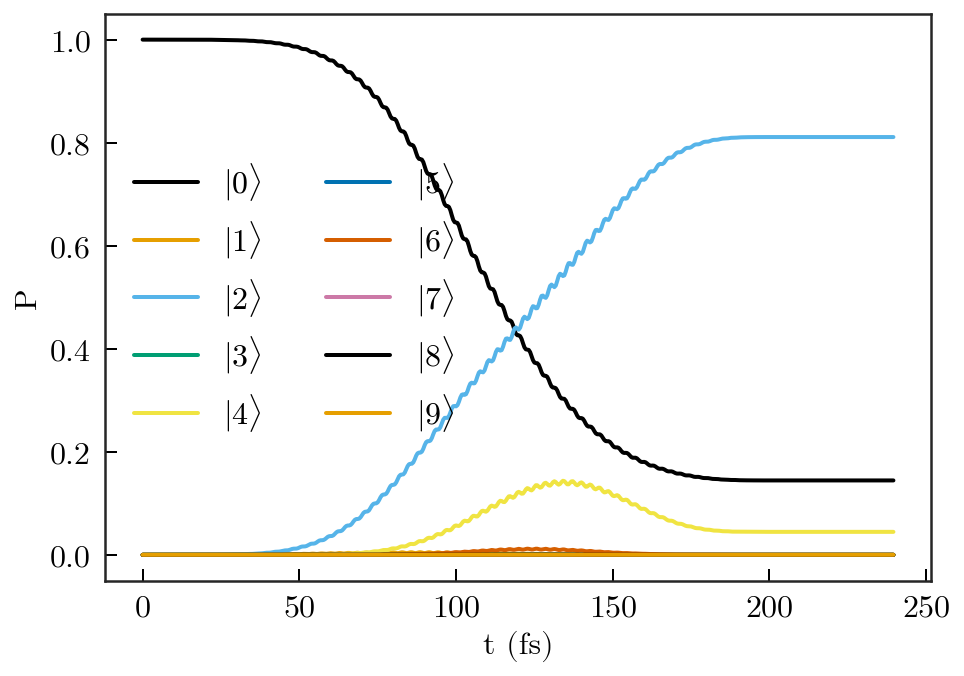

In [17]:
for ip in range(2*N):
    plt.plot(result.times,probs_pol[:,ip],label=fr"$|{ip}\rangle$");
plt.legend(ncol=2)
plt.xlabel("t (fs)")
plt.ylabel("P")
plt.tight_layout(pad=0)

Convert result to eigenbasis of $H_0$ (polaritons)

In [16]:
U = np.array([v.full() for v in vecs]).squeeze()
assert (U.imag==0).all()
U = U.real
ψs_pol = ψs @ U.T
probs_pol = abs(ψs_pol)**2

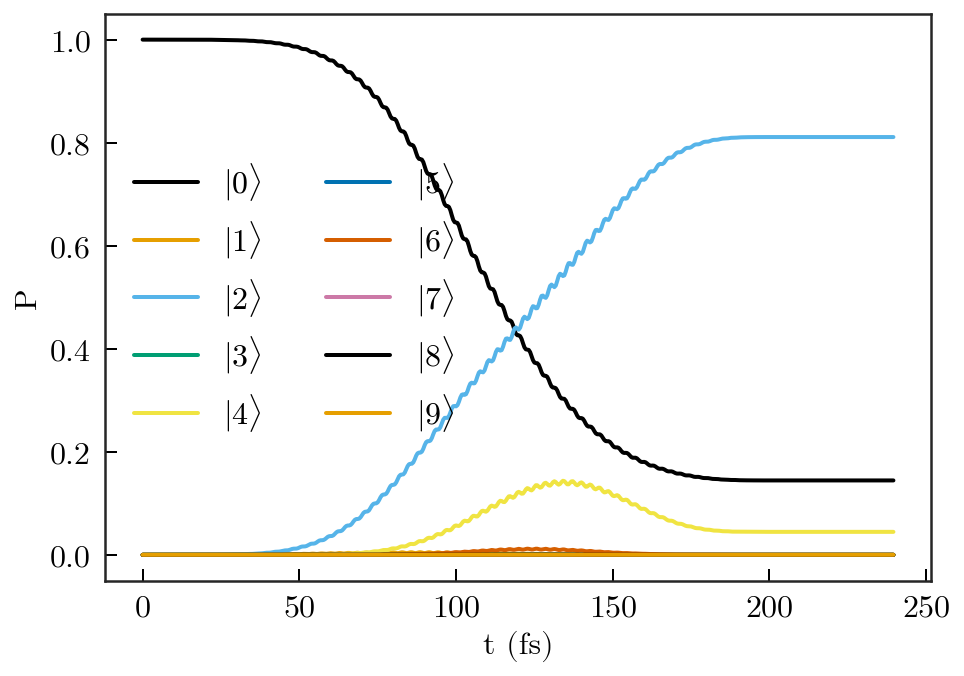

In [14]:
for ip in range(2*N):
    plt.plot(result.times,probs_pol[:,ip],label=fr"$|{ip}\rangle$");
plt.legend(ncol=2)
plt.xlabel("t (fs)")
plt.ylabel("P")
plt.tight_layout(pad=0)

## Drive to two-excitation subspace
Try to drive the transition from the ground to the two-excitation LP (state 3) resonantly with a two-photon process

In [15]:
print(vals[3]-vals[0])
args = dict(omegaL = (vals[3]-vals[0])/2,  # frequency
            T      = 200., # duration
            Omega  = 0.04)  # peak amplitude (μ·E0)

tmax = 1.2*args['T']
ts = np.arange(0,tmax,0.5/args['omegaL'])

1.858902049257277


In [16]:
result = sesolve(H,ψ0,ts,args=args,options=Options(rtol=1e-8,atol=1e-10))

In [17]:
ψs = np.array([ψ.full() for ψ in result.states]).squeeze()
probs = (abs(ψs)**2).reshape(len(ts),N,2)
probs.shape

(447, 5, 2)

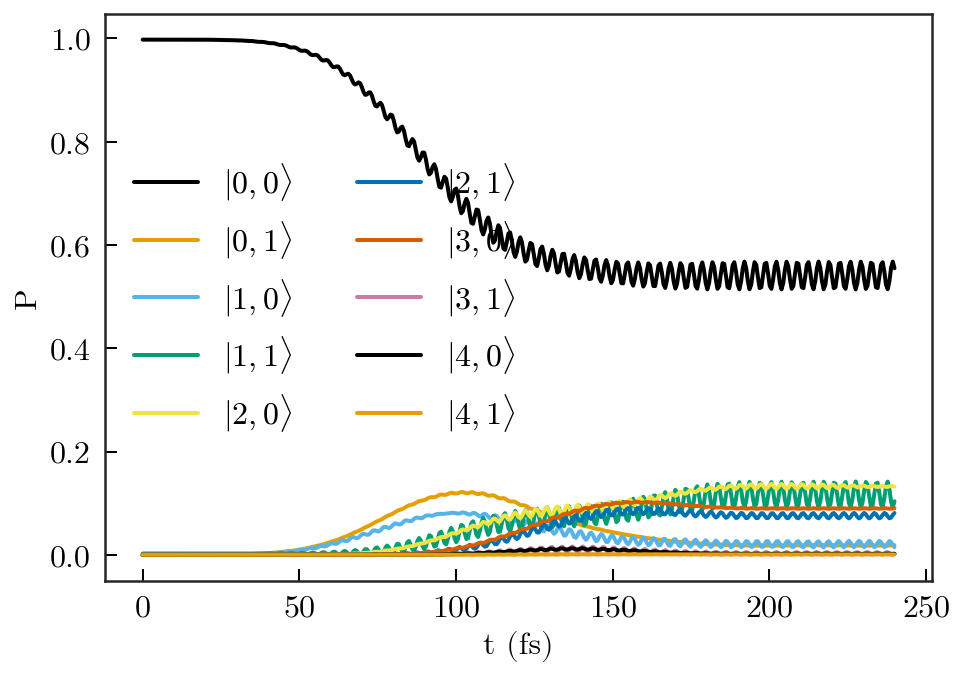

In [18]:
for ic in range(N):
    for ie in range(2):
        plt.plot(result.times,probs[:,ic,ie],label=fr"$|{ic},{ie}\rangle$");
plt.legend(ncol=2)
plt.xlabel("t (fs)")
plt.ylabel("P")
plt.tight_layout(pad=0)

Convert result to eigenbasis of $H_0$ (polaritons)

In [19]:
U = np.array([v.full() for v in vecs]).squeeze()
assert (U.imag==0).all()
U = U.real
ψs_pol = ψs @ U.T
probs_pol = abs(ψs_pol)**2

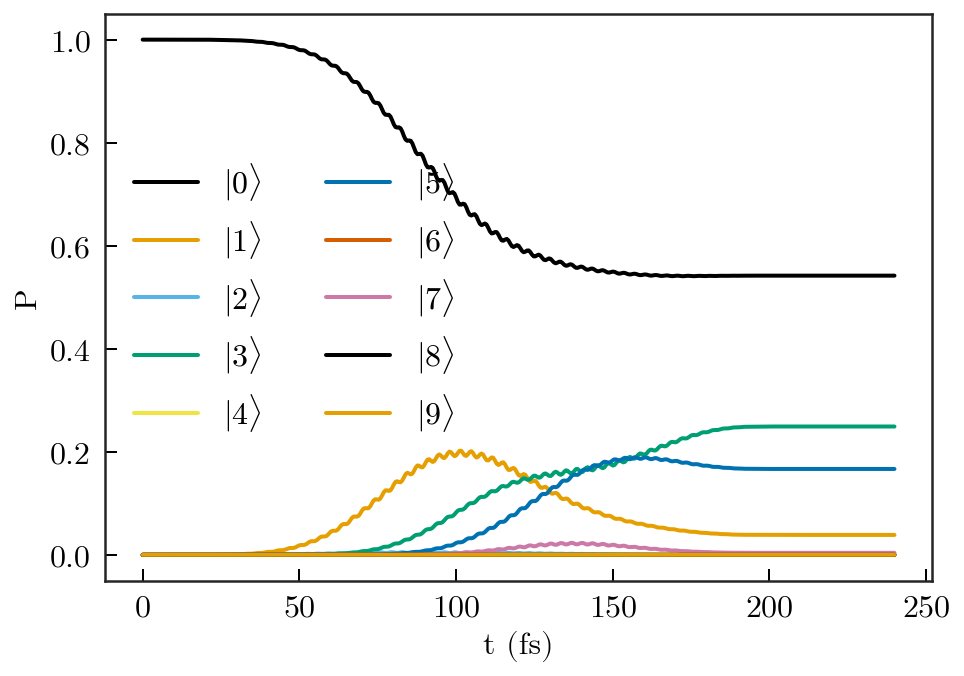

In [20]:
for ip in range(2*N):
    plt.plot(result.times,probs_pol[:,ip],label=fr"$|{ip}\rangle$");
plt.legend(ncol=2)
plt.xlabel("t (fs)")
plt.ylabel("P")
plt.tight_layout(pad=0)

## Disipación

In [18]:
#Parametros:
gamma=0.01
c_ops=[np.sqrt(gamma)*a]

In [19]:
result2 = mesolve(H,ψ0,ts,c_ops,args=args,options=Options(rtol=1e-8,atol=1e-10))

[Text(0, 0.5, '$\\langle N \\rangle$')]

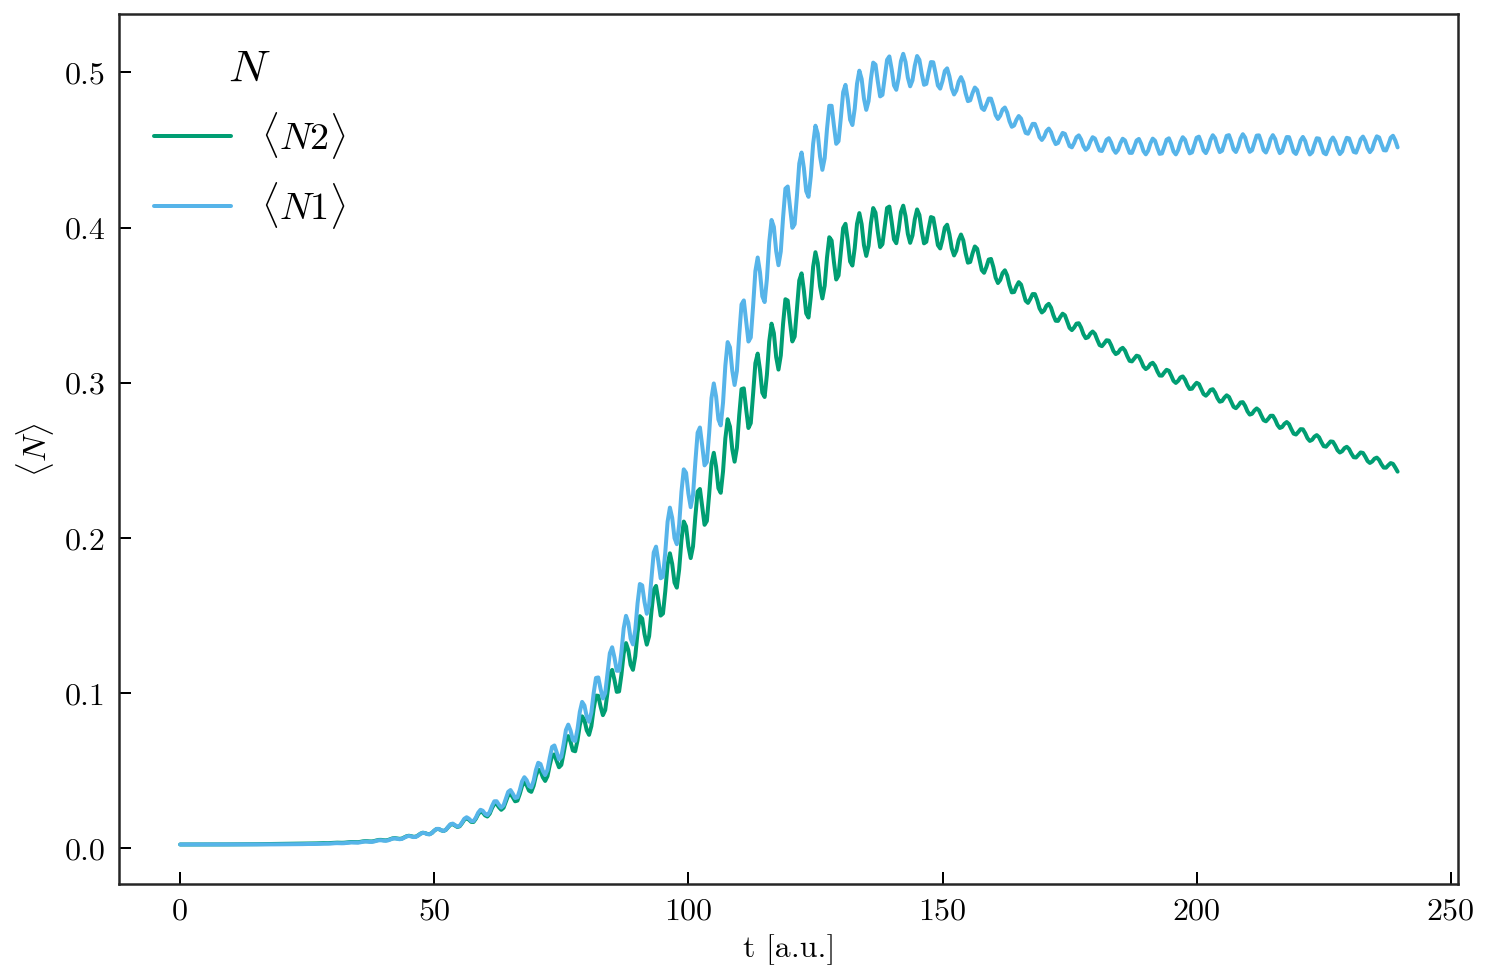

In [23]:
expectn2 = expect(a.dag()*a,result2.states)
fig, ax = plt.subplots(1, 1,figsize=(12, 8))
ax.plot(ts,expectn2,color="C3",lw=2,label=r'$\langle N2 \rangle$')
ax.plot(ts,expectn1,color="C2",lw=2,label=r'$\langle N1 \rangle$')
leg = ax.legend(loc=2,fontsize = 'large')
leg.set_title(r'$N$', prop = {'size':'x-large'})
ax.set(xlabel='t [a.u.]')
ax.set(ylabel=r'$\langle N \rangle$')
#plt.rc('font', size = 18)

In [29]:
result2.states[0].eigenenergies()

array([-7.04257742e-19, -3.33725219e-21, -2.58610481e-42,  0.00000000e+00,
        3.37346771e-53,  1.36749945e-37,  2.76979465e-26,  2.50387078e-24,
        2.70520128e-19,  1.00000000e+00])

/share/apps/anaconda/juhu/lib/python3.6/site-packages/qutip/visualization.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/share/apps/anaconda/juhu/lib/python3.6/site-packages/qutip/visualization.py:331: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

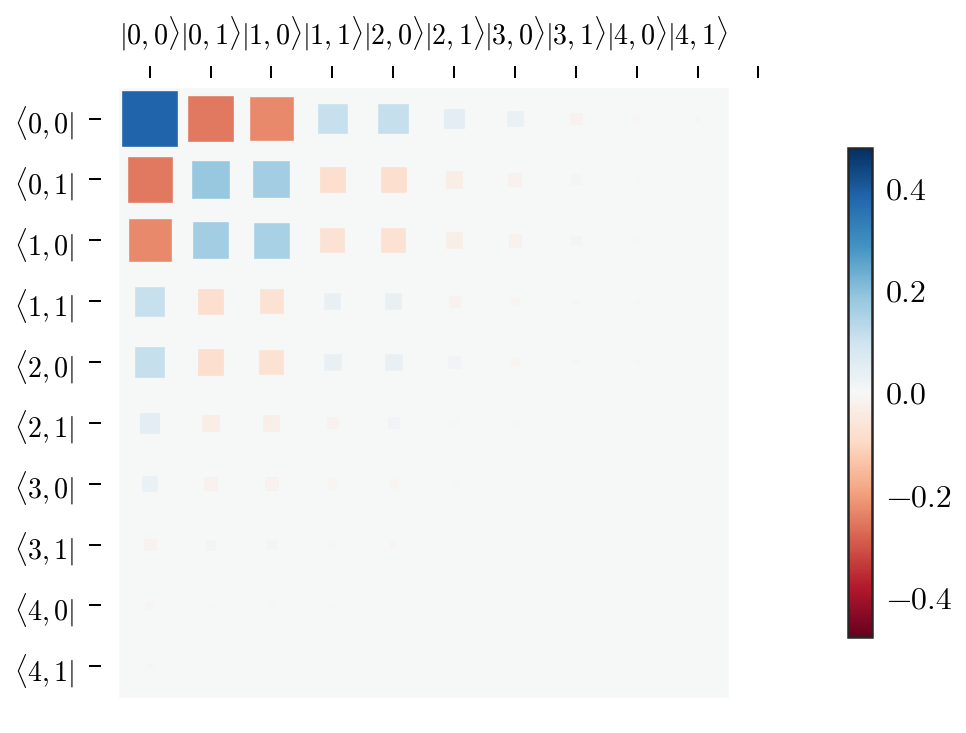

In [35]:
hinton(result2.states[270])

In [34]:
len(ts)

528

/share/apps/anaconda/juhu/lib/python3.6/site-packages/qutip/visualization.py:718: UserWarning: Deprecated: Use plot_energy_levels
  warnings.warn("Deprecated: Use plot_energy_levels")


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

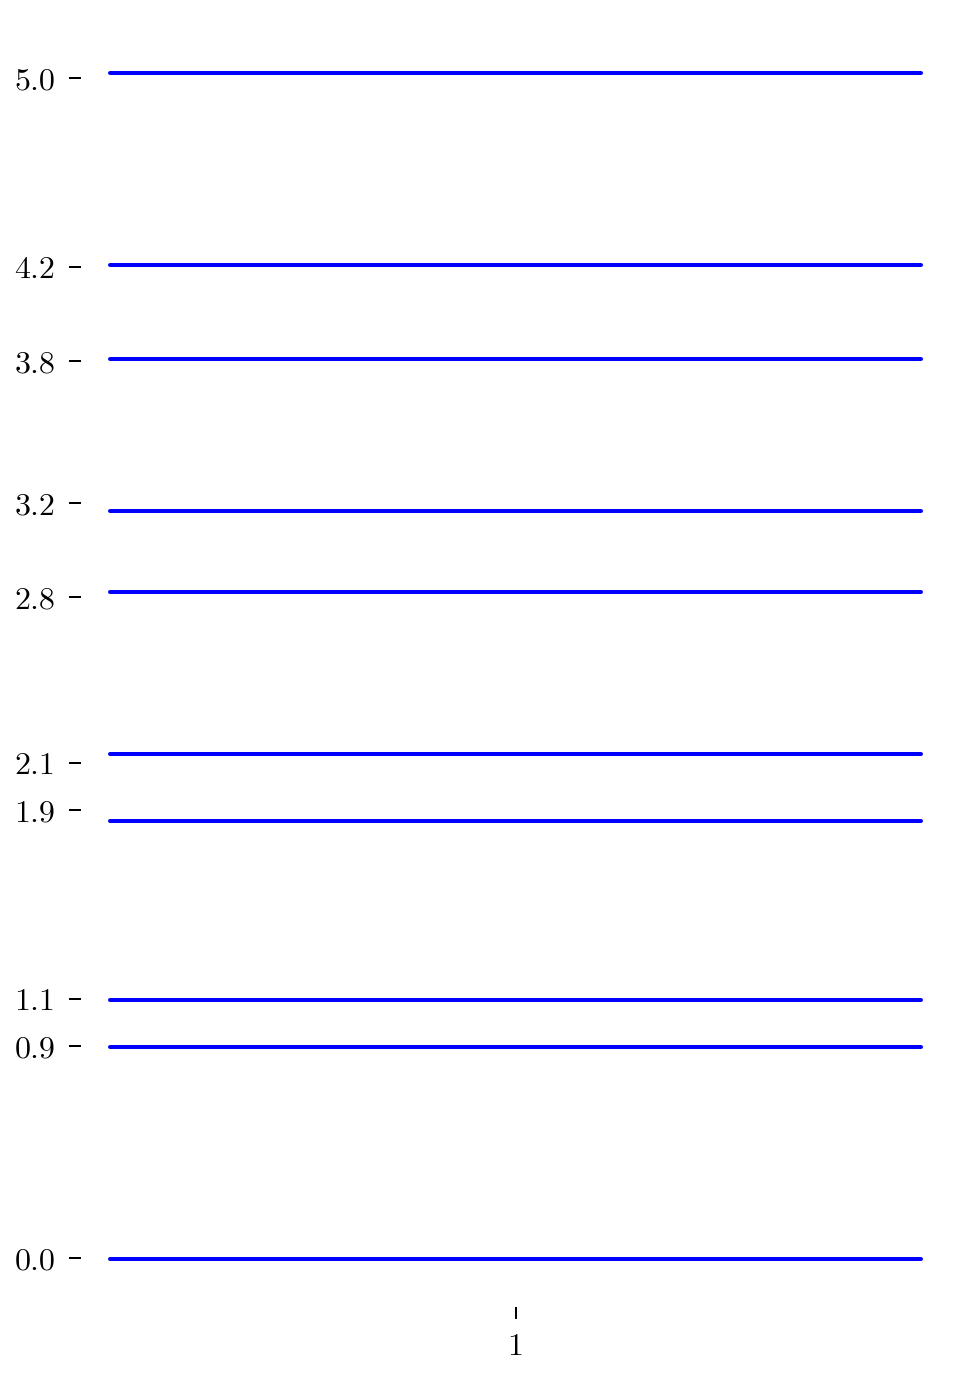

In [36]:
d=energy_level_diagram([H0], labels=[r'$H_a+H_b$',r'$H_{int}$'],show_ylabels=True)#,show_ylabels=True
#plt.savefig('diagrama-e.png')

/share/apps/anaconda/juhu/lib/python3.6/site-packages/qutip/visualization.py:718: UserWarning: Deprecated: Use plot_energy_levels
  warnings.warn("Deprecated: Use plot_energy_levels")


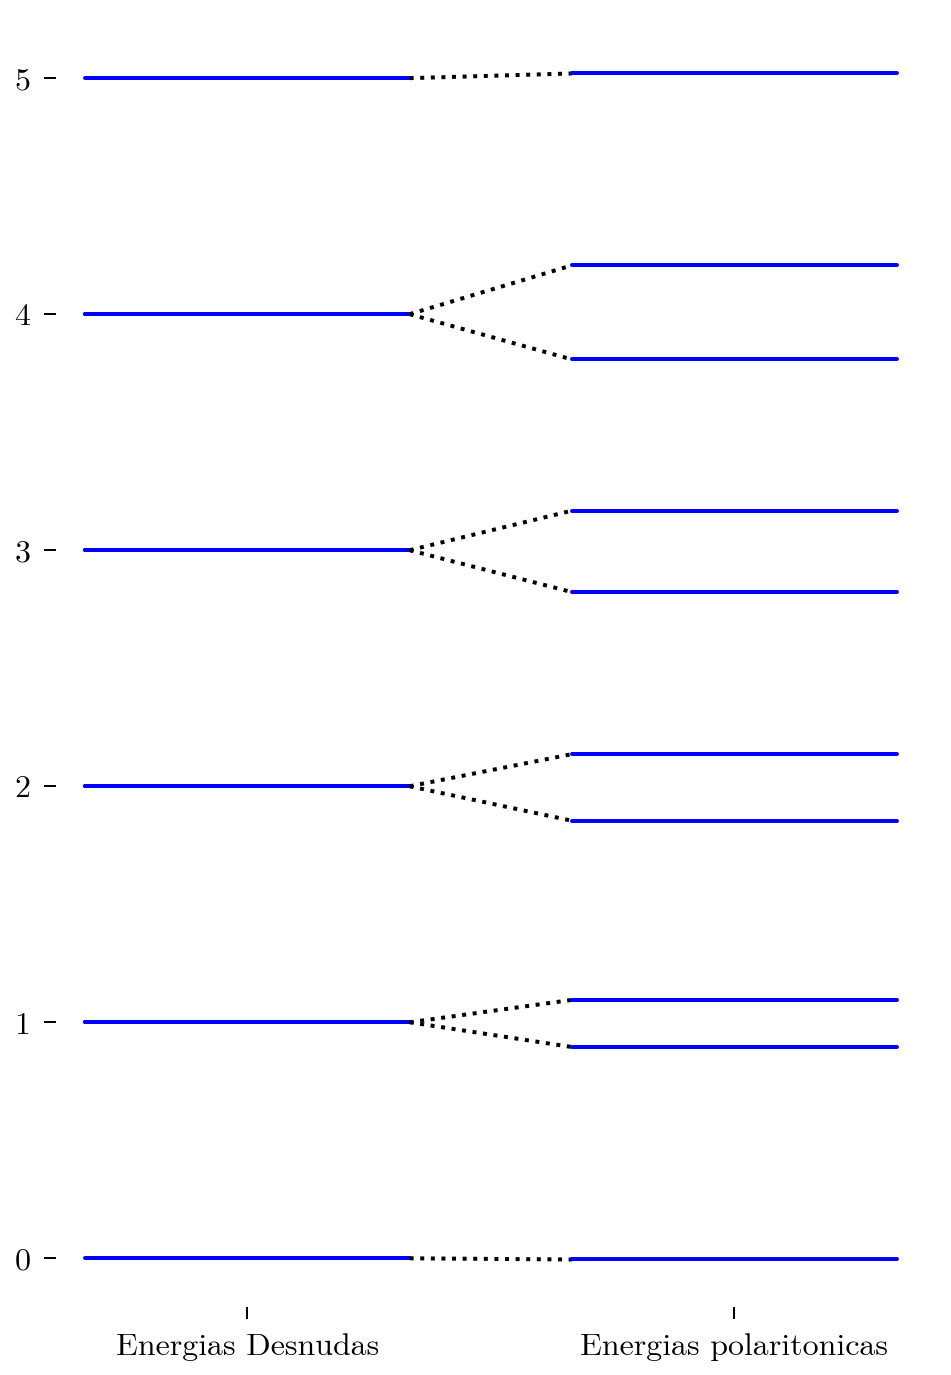

In [39]:
H01 = ωe*σ.dag()*σ + ωc*a.dag()*a
H02 = g*(σ+σ.dag())*(a+a.dag())
d=energy_level_diagram([H01,H02], labels=['Energias Desnudas','Energias polaritonicas'],show_ylabels=True)#,show_ylabels=True
#plt.savefig('diagrama-e.png')